# Red Wine Quality

Kaggle link: https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009

## Preliminaries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import metrics
import random
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import torch
from imblearn.over_sampling import SMOTE
from torch import nn
from sklearn.model_selection import train_test_split
#import wandb
#wandb.init(project="simple_regression")
from matplotlib import pyplot as plt

import os
for dirname, _, filenames in os.walk('./'): # '/kaggle/input'
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./simple-regression.ipynb
./winequality-red.csv


## Data Processing

In [2]:
train_data = pd.read_csv('./winequality-red.csv')    #'/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv'
train_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Let's see if the dataset is balanced w.r.t. the quality labels.

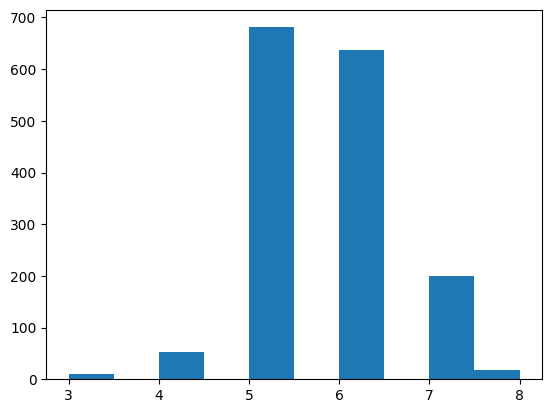

In [3]:
plt.hist(train_data.values[:,-1])   #plotting the last column of the dataset
plt.show()

As we can see, there are _unbalanced_ categories. 

First we will split the training set in two parts: *training* and *test* set. \
30% will be used as test set

In [4]:
X_train,X_test,y_train,y_test = train_test_split(train_data.iloc[:,:-1],train_data.iloc[:,-1],test_size=0.30) #splitting into training set and test set

Now we will use SMOTE to add new examples with labels 3,4 and 8 and re-balance the dataset.

Data before augmentation: quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64
Data after augmentation: quality
5    476
7    476
6    476
4    476
8    476
3    476
Name: count, dtype: int64


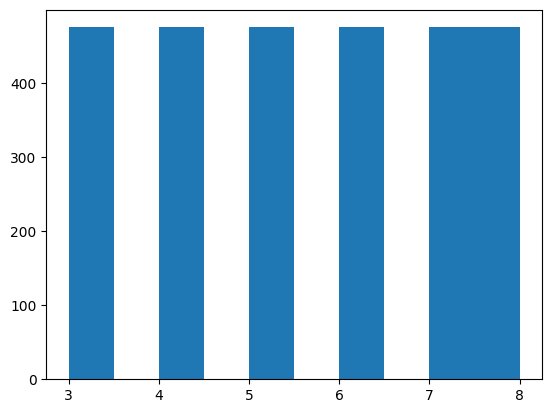

In [5]:
smt = SMOTE()
X_train,y_train = smt.fit_resample(X_train,y_train)
print("Data before augmentation:\f",train_data['quality'].value_counts())
print("Data after augmentation:\f",y_train.value_counts())

plt.hist(y_train)   #plotting the last column of the dataset
plt.show()

As we can see, now data is slightly more balanced

Now we will *normalize* features in the following manner:
- mean and std will be computed on the *training* set
- these values will be used to compute the normalization on the *test* set

In [6]:
def normalize_features(X_train, X_test, y_train, y_test):
    global train_mean, train_std, pred_mean, pred_std

    train_mean = [0,0,0,0,0,0,0,0,0,0,0] 
    train_std =[0,0,0,0,0,0,0,0,0,0,0]
    
    
    for i in range(0, X_train.shape[1]-1):
        train_mean[i] = X_train[i].mean()
        train_std[i] = X_train[i].std()
    
        X_train = (X_train - train_mean[i])/train_std[i]
        X_test = (X_test - train_mean[i])/train_std[i]
    
    print(X_train)
    
    pred_mean = y_train.mean()
    pred_std = y_train.std()
    
    y_train = (y_train - pred_mean) / pred_std
    y_train = torch.tensor(y_train,dtype=torch.float32)

    
    y_test = (y_test - pred_mean) / pred_std
    y_test = torch.tensor(y_test,dtype=torch.float32)
    return X_train, X_test, y_train, y_test

def denormalize_features(X_train, X_test, y_train, y_test):
    global train_mean, train_std, pred_mean, pred_std
    
    
    for i in range(0, X_train.shape[1]-1):
        X_train = (X_train*train_std[i])+train_mean[i]
        X_test = (X_test*train_std[i])+train_mean[i]
    
    y_train = (y_train * pred_std)+pred_mean
    y_train = torch.tensor(y_train,dtype=torch.float32)

    
    y_test = (y_test*pred_std) + pred_mean
    y_test = torch.tensor(y_test, dtype=torch.float32)
    return X_train, X_test, y_train, y_test

#convert the sets from ndarray to tensor
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

X_train_N,X_test_N,y_train_n,y_test_n = normalize_features(X_train,X_test,y_train,y_test)   #normalizing the dataset

tensor([[-0.1606, -0.4670, -0.4786,  ..., -0.3639, -0.4711, -0.1494],
        [-0.2017, -0.4552, -0.4849,  ..., -0.3643, -0.4651, -0.1083],
        [-0.1046, -0.4696, -0.4715,  ..., -0.3728, -0.4674, -0.1419],
        ...,
        [-0.1051, -0.4769, -0.4693,  ..., -0.3717, -0.4619, -0.0701],
        [-0.0976, -0.4766, -0.4694,  ..., -0.3717, -0.4635, -0.0741],
        [-0.1235, -0.4752, -0.4719,  ..., -0.3685, -0.4645, -0.0672]])


/var/folders/47/wgqjbdx10d91c2t28x5n0s5m0000gn/T/ipykernel_35420/3148631505.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train,dtype=torch.float32)
/var/folders/47/wgqjbdx10d91c2t28x5n0s5m0000gn/T/ipykernel_35420/3148631505.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test,dtype=torch.float32)


## Training

Initialize the weights and bias of the linear regression

In [7]:
n_features = X_train.shape[1] 
weights = torch.randn((n_features),requires_grad=True) # initialize a random tensor of weights, one weight for each feature
bias = torch.zeros(1, requires_grad=True)

Some functions definitions

In [8]:
from matplotlib import pyplot as plt

def linreg(X, w, b):        #linear regression
    return torch.matmul(X, w) + b

def sgd(params, lr, batch_size):    #we will use stochastic GD
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
            
criterion = nn.MSELoss()    #the loss function will be mean squared error

def data_iter(batch_size, features, labels):    #to divide a single batch in multiple minibatches
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i +
                                                   batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

def print_result(y_true, y_pred):       #plot the graphs
    plt.clf()
    plt.plot(y_pred, 'ro', label='Predictions', alpha=0.5)
    plt.plot(y_true, 'go', label='True', alpha=0.5)
    plt.legend(loc='best')
    plt.colorbar
    plt.show()
    
def print_correctness(ground_truth,predicted_labels):       #prints the accuracy
    print('Mean Squared Error:\f',metrics.mean_squared_error(ground_truth,predicted_labels))
    print('Mean Absolute Error:\f',metrics.mean_absolute_error(ground_truth,predicted_labels))
    print('R-squared:\f',metrics.r2_score(ground_truth,predicted_labels))

Training loop

In [9]:
# MINI BATCH, calculate for each round the derivative for each minibatch, and then sum up them together
num_iterations = 512
batch_size = 16
lr = 1e-3
print('Training loss:')
for i in range(num_iterations):
    for X, y in data_iter(batch_size, X_train_N, y_train_n):   
        loss = squared_loss(linreg(X,weights,bias),y)    #calculate the prediction, i.e. X(train features) * weights +b; then the loss w.r.t. labels
        loss.sum().backward() #derivate calc
        sgd([weights,bias],lr,batch_size)   #update weights
    with torch.no_grad():
        train_l = squared_loss(linreg(X, weights, bias), y) #loss of the final batch of the round
        print(f'epoch {i + 1}, loss {float(train_l.mean()):f}')
    

Training loss:
epoch 1, loss 0.734749
epoch 2, loss 0.691979
epoch 3, loss 0.376289
epoch 4, loss 0.602727
epoch 5, loss 0.670586
epoch 6, loss 0.753906
epoch 7, loss 0.590543
epoch 8, loss 0.609394
epoch 9, loss 0.421111
epoch 10, loss 0.363960
epoch 11, loss 0.694450
epoch 12, loss 0.631529
epoch 13, loss 0.496053
epoch 14, loss 0.476458
epoch 15, loss 0.525334
epoch 16, loss 0.483734
epoch 17, loss 0.355897
epoch 18, loss 0.789090
epoch 19, loss 0.277320
epoch 20, loss 0.511468
epoch 21, loss 0.359078
epoch 22, loss 0.465783
epoch 23, loss 0.568751
epoch 24, loss 0.554865
epoch 25, loss 0.746927
epoch 26, loss 0.394206
epoch 27, loss 0.492000
epoch 28, loss 0.466613
epoch 29, loss 0.700247
epoch 30, loss 0.407220
epoch 31, loss 0.400485
epoch 32, loss 0.590526
epoch 33, loss 0.423103
epoch 34, loss 0.802758
epoch 35, loss 0.388726
epoch 36, loss 0.497113
epoch 37, loss 0.178648
epoch 38, loss 0.456796
epoch 39, loss 0.338774
epoch 40, loss 0.519720
epoch 41, loss 0.367292
epoch 42, 

## Testing

We need to calculate the loss also over the test set

In [10]:
# test on the test dataset
with torch.no_grad():
    test_l = 0
    for X, y in data_iter(batch_size, X_test_N, y_test_n):
        test_l += squared_loss(linreg(X, weights, bias), y).sum()
    test_l /= len(X_test)
    print(f'loss on the test dataset {float(test_l):f}')

loss on the test dataset 0.106288


## Results

Finally, the obtained predictions are the following. 

We will evaluate the model using the following metrics:
- **Mean Squared Error**: computes the average of the squared differences between predicted and actual values.
- **Mean Absolute Error**: calculates the average absolute difference between the predicted and actual values.
- **R-squared**: indicates the proportion of the variance in the dependent variable that is predictable from the independent variables.

Mean Squared Error: 0.62023157
Mean Absolute Error: 0.60356396
R-squared: 0.0772878807331091


/var/folders/47/wgqjbdx10d91c2t28x5n0s5m0000gn/T/ipykernel_35420/3148631505.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train,dtype=torch.float32)
/var/folders/47/wgqjbdx10d91c2t28x5n0s5m0000gn/T/ipykernel_35420/3148631505.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)


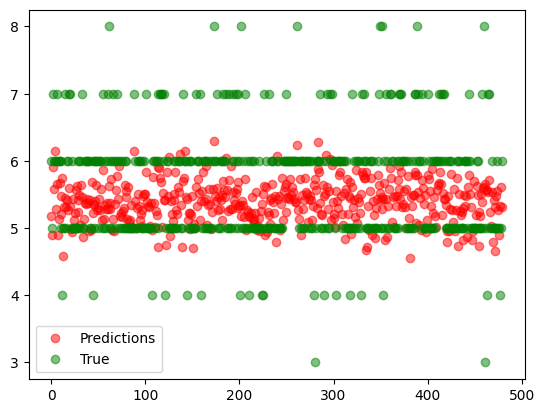

In [11]:
test_predictions_N = []
with torch.no_grad():
    for X in X_test_N:
        test_predictions_N.append(linreg(X,weights,bias))       #we calculate all the predictions on the test set

_,_,test_predictions,y_test = denormalize_features(X_train_N,X_test_N,torch.tensor(test_predictions_N),y_test_n)    #we denormalize the features

#test_predictions = test_predictions.round()     #aproximation, since we need int values

with torch.no_grad():
    print_correctness(y_test,test_predictions)  #prints accuracy
    print_result(y_test,test_predictions)
    

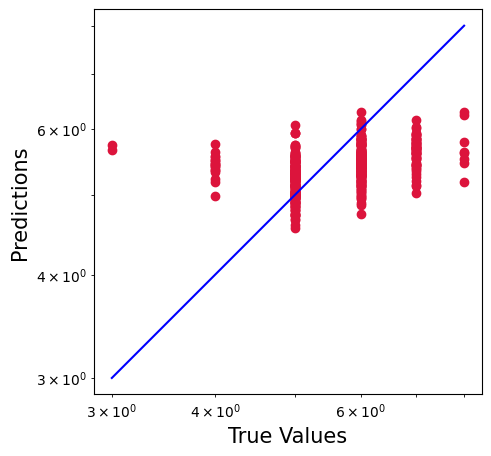

In [12]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, test_predictions, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_test), max(test_predictions))
p2 = min(min(test_predictions), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()